In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager

import pandas as pd
import datetime

options = Options()
options.headless = True

driver = webdriver.Chrome(options=options, service=ChromeService(
    ChromeDriverManager().install()))


[WDM] - Downloading: 100%|██████████| 6.46M/6.46M [00:04<00:00, 1.49MB/s]


In [2]:
url = 'https://www.transfermarkt.com/weltmeisterschaft-2022/gesamtspielplan/pokalwettbewerb/WM22/saison_id/2021'


In [4]:
driver.get(url)
nt = driver.find_elements(
    By.CSS_SELECTOR, '.large-6.columns .grid-view table.items tbody tr')


In [5]:
nt_list = []
for i in range(len(nt)):
    nt_name = nt[i].find_element(
        By.CSS_SELECTOR, 'td:nth-child(3) a:nth-child(1)').get_attribute('title')
    nt_url = nt[i].find_element(
        By.CSS_SELECTOR, 'td:nth-child(3) a:nth-child(1)').get_attribute('href')
    flag_url = nt[i].find_element(
        By.CSS_SELECTOR, 'td:nth-child(2) .flaggenrahmen').get_attribute('href')
    squad_url = f"{nt_url.replace('spielplan','kader')}/plus/1"
    nt_list.append({
        'nt_name': nt_name,
        'nt_url': nt_url,
        'flag_url': flag_url,
        'squad_url': squad_url,
    })
nt_df = pd.DataFrame(nt_list)
nt_df.to_excel('../../../data/wc22_team.xlsx')


In [2]:
def get_wc22_squad(driver, url):
    driver.get(url)
    players = driver.find_elements(By.CSS_SELECTOR, '#yw1 .items > tbody > tr')
    try:
        country = driver.find_element(
            By.CSS_SELECTOR, '.data-header__headline-container').text
    except:
        country = None
    player_list = []
    print(f"Get {country} squad :")
    for i in range(len(players)):
        name = players[i].find_element(
            By.CSS_SELECTOR, 'td:nth-child(2) table img').get_attribute('title')
        src = players[i].find_element(
            By.CSS_SELECTOR, 'td:nth-child(2) table img').get_attribute('data-src')
        dob = players[i].find_element(
            By.CSS_SELECTOR, 'td:nth-child(3)').get_attribute('innerHTML')
        club = players[i].find_element(
            By.CSS_SELECTOR, 'td:nth-child(4) a').get_attribute('title')
        club_url = players[i].find_element(
            By.CSS_SELECTOR, 'td:nth-child(4) a').get_attribute('href')
        height = players[i].find_element(
            By.CSS_SELECTOR, 'td:nth-child(5)').get_attribute('innerHTML')
        caps = players[i].find_element(
            By.CSS_SELECTOR, 'td:nth-child(7)').get_attribute('innerHTML')
        market_value = players[i].find_element(
            By.CSS_SELECTOR, 'td:nth-child(10)').get_attribute('innerHTML')
        position = players[i].find_element(
            By.CSS_SELECTOR, 'td:nth-child(2) tbody tr:nth-child(2) td').get_attribute('innerHTML').strip()
        print(f"{i+1}. {name} - {position}")

        player_list.append({
            'name': name,
            'position': position,
            'dob': dob,
            'club': club,
            'club_url': club_url,            
            'caps': caps,
            'height': height,
            'market_value': market_value,
            'country': country
        })
    player_df = pd.DataFrame(player_list).reset_index(drop=True)
    return player_df


In [245]:
def get_club_detail(driver, url):
    driver.get(url)    
    try:
        league = driver.find_element(
            By.CSS_SELECTOR, '.data-header__box--big .data-header__club').text
    except:
        league = None
    try:
        league_country = driver.find_element(
            By.CSS_SELECTOR, '.data-header__box--big .flaggenrahmen').get_attribute('title')
    except:
        league_country = None
    try:
        league_tier = driver.find_element(
            By.CSS_SELECTOR, '.data-header__box--big .data-header__label .data-header__content a').text
    except:
        league_tier = None
    c = {
        'club_url': url,
        'league': league,
        'league_country': league_country,
        'league_tier': league_tier
    }
    return c


In [3]:
nt_df = pd.read_excel('../../../data/wc22_team.xlsx',index_col=0)
li = list(nt_df['squad_url'])

In [5]:
sq_df = pd.DataFrame()
for i in range(len(li)):
    d = get_wc22_squad(driver,li[i])
    sq_df = pd.concat([sq_df,d]).reset_index(drop=True)

Get Netherlands squad :
1. Justin Bijlow - Goalkeeper
2. Andries Noppert - Goalkeeper
3. Remko Pasveer - Goalkeeper
4. Matthijs de Ligt - Centre-Back
5. Virgil van Dijk - Centre-Back
6. Jurrien Timber - Centre-Back
7. Nathan Aké - Centre-Back
8. Stefan de Vrij - Centre-Back
9. Tyrell Malacia - Left-Back
10. Daley Blind - Left-Back
11. Jeremie Frimpong - Right-Back
12. Teun Koopmeiners - Defensive Midfield
13. Marten de Roon - Defensive Midfield
14. Frenkie de Jong - Central Midfield
15. Kenneth Taylor - Central Midfield
16. Denzel Dumfries - Right Midfield
17. Xavi Simons - Attacking Midfield
18. Steven Berghuis - Attacking Midfield
19. Davy Klaassen - Attacking Midfield
20. Cody Gakpo - Left Winger
21. Steven Bergwijn - Left Winger
22. Noa Lang - Left Winger
23. Memphis Depay - Centre-Forward
24. Wout Weghorst - Centre-Forward
25. Vincent Janssen - Centre-Forward
26. Luuk de Jong - Centre-Forward
Get Senegal squad :
1. Edouard Mendy - Goalkeeper
2. Alfred Gomis - Goalkeeper
3. Seny Di

In [6]:
sq_df.to_excel("../../../data/wc22_squad.xlsx")

In [185]:
sq_df = pd.read_excel("../../../data/wc22_squad.xlsx",index_col=0)

In [ ]:
wc22_club = sq_df.groupby(['club','club_url'])['name'].count().reset_index(
    name='count').sort_values(['count'],ascending=False).reset_index(drop=True)
wc22_club.to_excel('../../../data/wc22_club.xlsx')

In [234]:
club_df = pd.read_excel('../../../data/wc22_club.xlsx',index_col=0)

In [248]:
c_list = []
for i in range(len(club_df)):
# for i in range(10):
    cd = get_club_detail(driver, club_df['club_url'][i])
    print(f"{i+1}. {club_df['club'][i]}")
    c_list.append(cd)
cd_df = pd.DataFrame(c_list)


https://www.transfermarkt.com/fc-barcelona/startseite/verein/131
1. FC Barcelona
https://www.transfermarkt.com/manchester-city/startseite/verein/281
2. Manchester City
https://www.transfermarkt.com/fc-bayern-munchen/startseite/verein/27
3. Bayern Munich
https://www.transfermarkt.com/al-sadd-sc/startseite/verein/656
4. Al-Sadd SC
https://www.transfermarkt.com/manchester-united/startseite/verein/985
5. Manchester United
https://www.transfermarkt.com/fc-chelsea/startseite/verein/631
6. Chelsea FC
https://www.transfermarkt.com/al-hilal-riad/startseite/verein/1114
7. Al-Hilal Saudi FC
https://www.transfermarkt.com/atletico-madrid/startseite/verein/13
8. Atlético de Madrid
https://www.transfermarkt.com/real-madrid/startseite/verein/418
9. Real Madrid
https://www.transfermarkt.com/fc-paris-saint-germain/startseite/verein/583
10. Paris Saint-Germain
https://www.transfermarkt.com/tottenham-hotspur/startseite/verein/148
11. Tottenham Hotspur
https://www.transfermarkt.com/juventus-turin/startseit

In [251]:
club_df = club_df.merge(cd_df,on=["club_url"],how='left')

In [252]:
club_df.to_excel('../../../data/wc22_club.xlsx')

In [253]:
club_df = pd.read_excel('../../../data/wc22_club.xlsx',index_col=0)

In [186]:
def format_market_value(mv):
    mv = str(mv).replace('€','')
    if mv[-1] == 'm':
        val = int(float(mv[:-1])*1000000)
    elif mv[-1] == 'k':
        val = int(float(mv[:-1])*1000)
    else:
        val = int(str(mv).replace('-','0'))
    return val


In [187]:
def format_caps(cap):
    c = str(cap).replace('-','0')
    c = int(c)
    return c

In [188]:
def format_height(h):
    he = str(h).replace('-','0')
    he = he.replace('m','')
    he = he.replace(',','.')
    he = int(float(he)*100)
    return he

In [189]:
def format_dob(d):
    d = d.split(' (')
    d = d[0]
    d = datetime.datetime.strptime(d, '%b %d, %Y').strftime('%d/%m/%Y')
    return d

In [190]:
def calculate_age(born):
    born = datetime.datetime.strptime(born,'%d/%m/%Y')
    today = datetime.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))


In [191]:
sq_df['market_value'] = sq_df['market_value'].map(
    lambda x: format_market_value(x))
sq_df['caps'] = sq_df['caps'].map(lambda x: format_caps(x))
sq_df['height'] = sq_df['height'].map(lambda x: format_height(x))
sq_df['dob'] = sq_df['dob'].map(lambda x: format_dob(x))
sq_df['age'] = sq_df['dob'].map(lambda x: calculate_age(x))


In [193]:
avg_age = sq_df.groupby('country')['age'].mean().reset_index(name='avg_age').sort_values('avg_age')
avg_mv = sq_df.groupby('country')['market_value'].mean().reset_index(name='avg_mv').sort_values('avg_mv')
avg_caps = sq_df.groupby('country')['caps'].mean().reset_index(name='avg_caps').sort_values('avg_caps')
sum_mv = sq_df.groupby('country')['market_value'].sum().reset_index(name='sum_mv').sort_values('sum_mv')

In [259]:
sq_df = sq_df.merge(club_df[['club_url', 'league', 'league_country',
            'league_tier']], on=['club_url'], how='left')


In [260]:
sq_df.to_excel('../../../data/wc22_squad_clean.xlsx')

In [194]:
sq_df_merge = sq_df.merge(avg_age,on=['country'],how='left')
sq_df_merge = sq_df_merge.merge(avg_mv,on=['country'],how='left')
sq_df_merge = sq_df_merge.merge(avg_caps,on=['country'],how='left')
sq_df_merge = sq_df_merge.merge(sum_mv,on=['country'],how='left')

In [313]:
import joypy
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import urllib


In [212]:
df = sq_df_merge.copy().sort_values('avg_mv',ascending=True)
df['market_value'] = df['market_value']/1000000
df = df[df['market_value']!=0]
df = df[df['height']!=0]
avg_mv = avg_mv.sort_values('avg_mv',ascending=True).reset_index(drop=True)

In [345]:
wc22_team = pd.read_excel('../../../data/wc22_team.xlsx',index_col=0)

In [346]:
wc22_team[wc22_team['country']==avg_mv['country'][0]]['flag_url'].iloc[0]

'https://tmssl.akamaized.net/images/flagge/head/137.png'

1. Qatar
2. Costa Rica
3. Saudi Arabia
4. Australia
5. Iran
6. Tunisia
7. Ecuador
8. Japan
9. Cameroon
10. Wales
11. South Korea
12. Mexico
13. Canada
14. Ghana
15. Senegal
16. Morocco
17. Poland
18. United States
19. Switzerland
20. Denmark
21. Serbia
22. Croatia
23. Uruguay
24. Belgium
25. Netherlands
26. Argentina
27. Spain
28. Germany
29. Portugal
30. France
31. Brazil
32. England


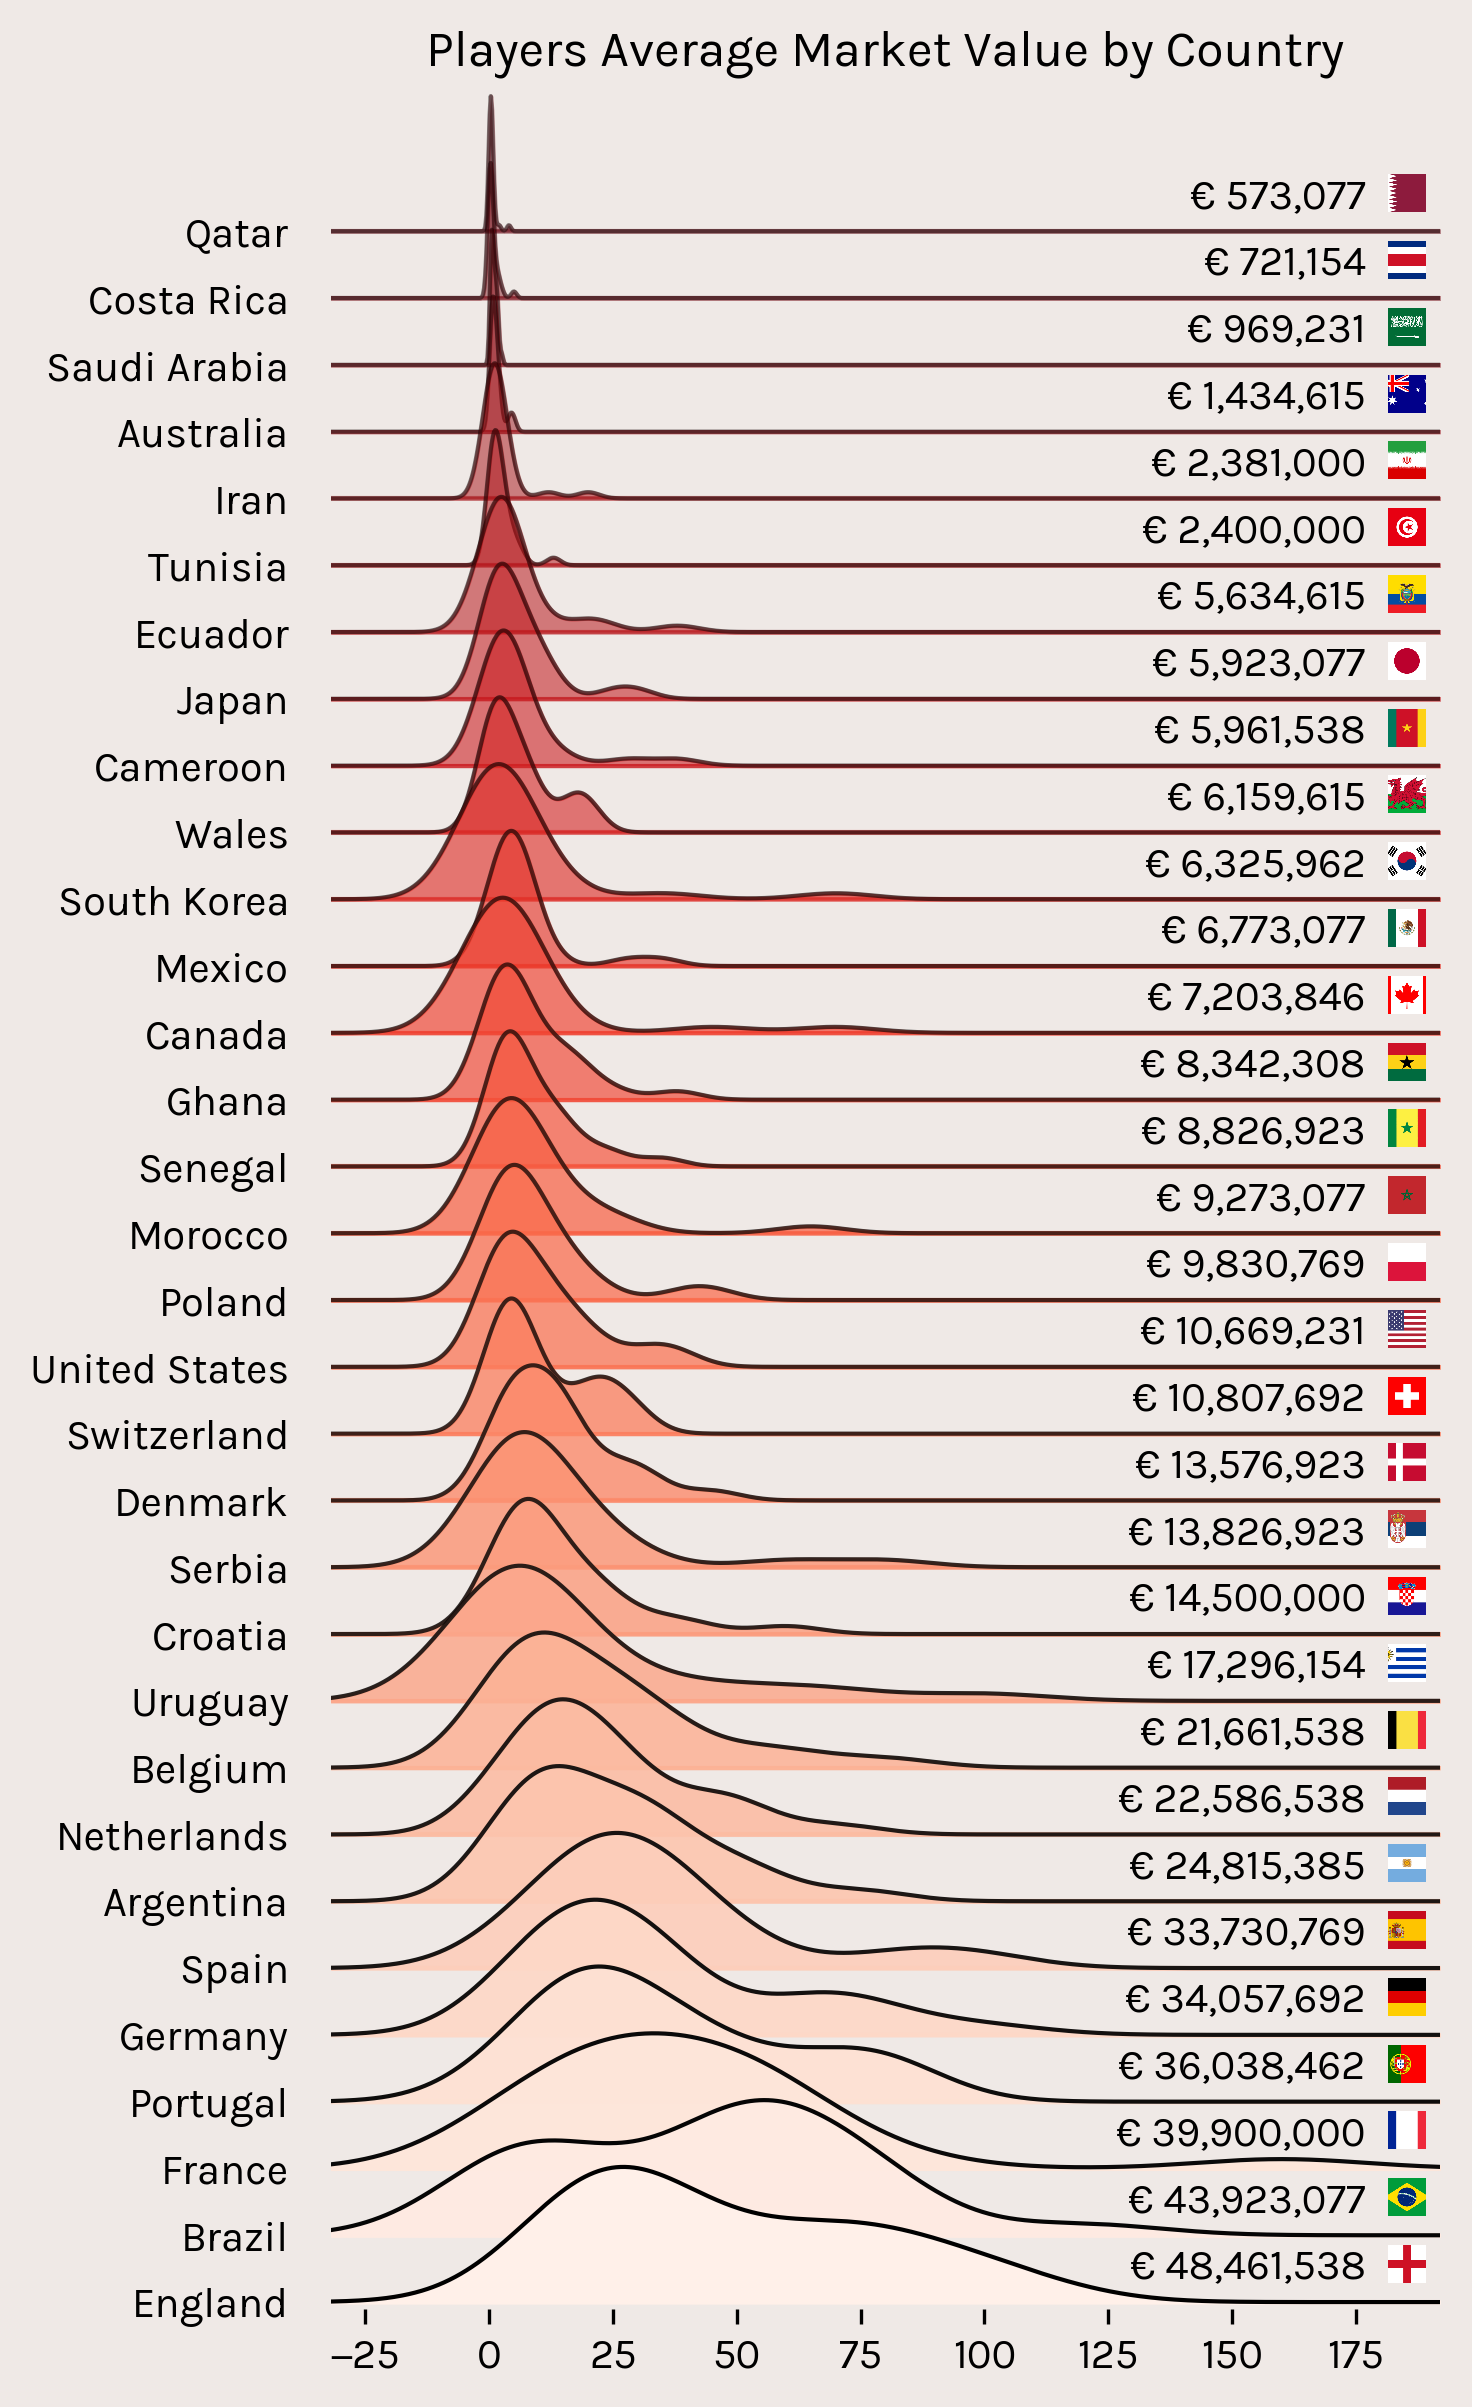

In [366]:
fig, axes = joypy.joyplot(df.groupby("country", sort=False),
                          # by="country",
                          column=['market_value'],
                          figsize=(5, 8),
                          linewidth=1,
                          overlap=.5,
                          colormap=[cm.Reds_r],
                          ylim="own",
                          fade=True,
                          background='#efe9e6'
                          #   grid='x',
                          #   bins=40,
                          # range_style='own'
                          # kind="kde",
                          #   x_range=[-11000000, 110000000]
                          )
fig.set_facecolor('#efe9e6')

for i in range(len(axes)-1):
    axes[i].annotate(f"€ {avg_mv['avg_mv'][i]:0,.0f}",
                     #  (avg_mv['avg_mv'][i]/1000000, axes[i].get_ylim()[1]),
                     (axes[i].get_xlim()[1]-15, .1*axes[i].get_ylim()[1]),
                     va="bottom", ha='right', font='Karla')
    flag_url = wc22_team[wc22_team['country'] ==
                         avg_mv['country'][i]]['flag_url'].iloc[0]
    flag = Image.open(urllib.request.urlopen(flag_url))
    im = OffsetImage(flag, zoom=.06)
    im.image.axes = axes[i]
    ab = AnnotationBbox(im, (.97, 0.3), xycoords='axes fraction', frameon=False)
    axes[i].add_artist(ab)
    print(f"{i+1}. {avg_mv['country'][i]}")

plt.rcParams["font.family"] = "Karla"
plt.rcParams["figure.dpi"] = "300"
plt.title("Players' Market Value Average by Country")

plt.show()
